In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats2020/inputData128/val/images/image_200.npy
/kaggle/input/brats2020/inputData128/val/images/image_273.npy
/kaggle/input/brats2020/inputData128/val/images/image_202.npy
/kaggle/input/brats2020/inputData128/val/images/image_57.npy
/kaggle/input/brats2020/inputData128/val/images/image_301.npy
/kaggle/input/brats2020/inputData128/val/images/image_345.npy
/kaggle/input/brats2020/inputData128/val/images/image_110.npy
/kaggle/input/brats2020/inputData128/val/images/image_277.npy
/kaggle/input/brats2020/inputData128/val/images/image_130.npy
/kaggle/input/brats2020/inputData128/val/images/image_149.npy
/kaggle/input/brats2020/inputData128/val/images/image_94.npy
/kaggle/input/brats2020/inputData128/val/images/image_283.npy
/kaggle/input/brats2020/inputData128/val/images/image_167.npy
/kaggle/input/brats2020/inputData128/val/images/image_16.npy
/kaggle/input/brats2020/inputData128/val/images/image_231.npy
/kaggle/input/brats2020/inputData128/val/images/image_70.npy
/kaggle/inpu

In [27]:
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
import random
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [28]:
def loadImage(imageDirectory, imageList):
    images = []
    for i, imageName in enumerate(imageList):    
        if (imageName.split('.')[1] == 'npy'):
            image = np.load(imageDirectory+"/"+imageName) 
            images.append(image)
    images = np.array(images)
    return images
def imageLoader(imageDirectory, imageList, maskDirectory, maskList, batchSize):
    length = len(imageList)
    while True:
        batchStart = 0
        batchEnd = batchSize
        while batchStart < length:
            limit = min(batchEnd, length)
            X = loadImage(imageDirectory, imageList[batchStart:limit])
            Y = loadImage(maskDirectory, maskList[batchStart:limit])
            X=X.astype('float32')
            Y=Y.astype('float32')
            yield (X,Y)    
            batchStart += batchSize   
            batchEnd += batchSize

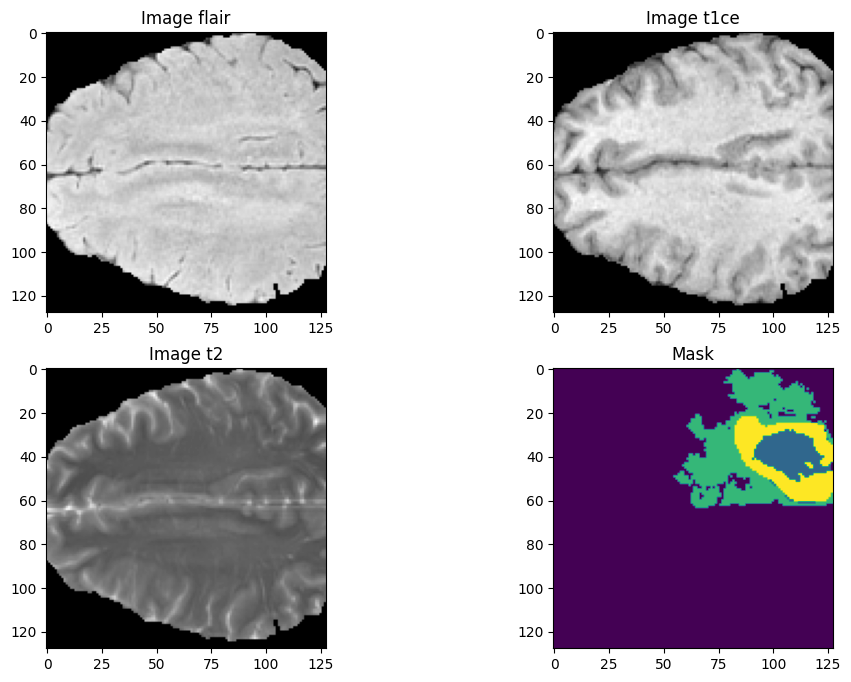

In [29]:
from matplotlib import pyplot as plt
import random

trainImageDirectory = "/kaggle/input/brats2020/inputData128/train/images"
trainMaskDirectory = "/kaggle/input/brats2020/inputData128/train/masks"
trainImageList=os.listdir(trainImageDirectory)
trainMaskList = os.listdir(trainMaskDirectory)

batchSize = 2

trainImageDatagenerator = imageLoader(trainImageDirectory, trainImageList, 
                                trainMaskDirectory, trainMaskList, batchSize)

#Verify generator.... In python 3 next() is renamed as __next__()
image, mask = trainImageDatagenerator.__next__()


imageNumber = random.randint(0,image.shape[0]-1)
testImage=image[imageNumber]
testMask=mask[imageNumber]
testMask=np.argmax(testMask, axis=3)

nSlice=random.randint(0, testMask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(testImage[:,:,nSlice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(testImage[:,:,nSlice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(testImage[:,:,nSlice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(testMask[:,:,nSlice])
plt.title('Mask')
plt.show()

In [30]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU


In [31]:
def unetThreeD(height,width,depth,numChannels, numClasses):

    inputs = Input((height,width,depth,numChannels))
    s = inputs
    
    
    c1 = Conv3D(16,   (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c1)
    p1 = MaxPooling3D( (2, 2, 2))(c1)
    
    c2 = Conv3D(32,  (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32,  (3, 3, 3),  activation='relu', kernel_initializer='he_uniform', padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu',  kernel_initializer='he_uniform', padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3),  activation='relu',  kernel_initializer='he_uniform',  padding='same')(c5)

    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128,  (3, 3, 3), activation='relu',  kernel_initializer='he_uniform', padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3),   activation='relu', kernel_initializer='he_uniform', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate( [u8, c2])
    c8 = Conv3D(32, (3, 3, 3),  activation='relu',   kernel_initializer='he_uniform', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer='he_uniform',  padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu',  kernel_initializer='he_uniform', padding='same')(c9)
     
    outputs = Conv3D( numClasses, (1, 1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [32]:
!pip install segmentation-models-3D

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [33]:
import numpy as np
import keras
from matplotlib import pyplot as plt
import glob
import random
trainImgDirectory = '/kaggle/input/brats2020/inputData128/train/images'
trainMaskDirectory = "/kaggle/input/brats2020/inputData128/train/masks"
imageList = os.listdir(trainImgDirectory)
maskList = os.listdir(trainMaskDirectory )

numImages = len(os.listdir(trainImgDirectory))

numImage = random.randint(0,numImages-1)
testImage = np.load(trainImgDirectory+'/'+imageList[numImage])
testMask = np.load(trainMaskDirectory+'/'+maskList[numImage])
testMask = np.argmax(testMask, axis=3)








In [34]:

columns = ['0', '1', '2', '3']
df = pd.DataFrame(columns=columns)
trainMaskList = sorted(glob.glob('/kaggle/input/brats2020/inputData128/train/masks/*.npy'))

for img in range(len(trainMaskList)):
    currImage= np.load(trainMaskList[img])
    currImage = np.argmax(currImage, axis=3)
    val, counts = np.unique(currImage, return_counts=True)
    countDict = dict.fromkeys(columns, 0)

    for value, count in zip(val, counts):
        countDict[str(value)] = count  
    rowDf = pd.DataFrame([countDict])
    df = pd.concat([df, rowDf], ignore_index=True)



label0 = df['0'].sum()
label1 = df['1'].sum()
label2 = df['1'].sum()
label3 = df['3'].sum()
totalLabels = label0 + label1 + label2 + label3
numClasses = 4
wt0 = round((totalLabels/(numClasses*label0)), 2) 
wt1 = round((totalLabels/(numClasses*label1)), 2)
wt2 = round((totalLabels/(numClasses*label2)), 2)
wt3 = round((totalLabels/(numClasses*label3)), 2)

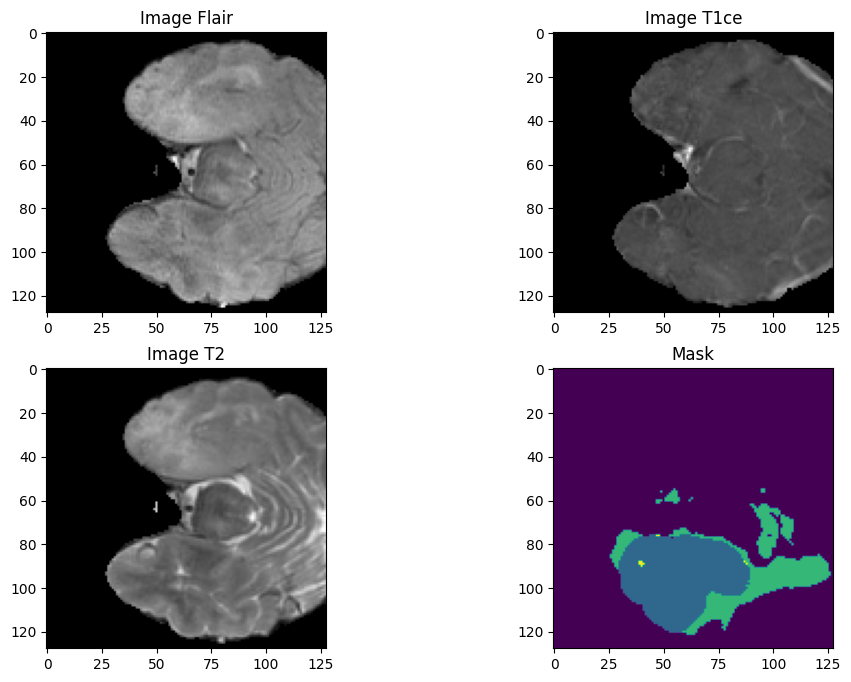

In [37]:
trainImageDir = "/kaggle/input/brats2020/inputData128/train/images"
trainMaskDir = "/kaggle/input/brats2020/inputData128/train/masks"

valImageDir = "/kaggle/input/brats2020/inputData128/val/images"
valMaskDir = "/kaggle/input/brats2020/inputData128/val/masks"

trainImageList = os.listdir(trainImageDir)
trainMaskList = os.listdir(trainMaskDir)

valImageList = os.listdir(valImageDir)
valMaskList = os.listdir(valMaskDir)

batchSize = 2

trainImageDataGenerator = imageLoader(trainImageDir, trainImageList, 
                                      trainMaskDir, trainMaskList, batchSize)

valImageDataGenerator = imageLoader(valImageDir, valImageList, 
                                    valMaskDir, valMaskList, batchSize)

imageBatch, maskBatch = trainImageDataGenerator.__next__()

imageNumber = random.randint(0, imageBatch.shape[0]-1)
testImage = imageBatch[imageNumber]
testMask = maskBatch[imageNumber]
testMask = np.argmax(testMask, axis=3)

sliceNumber = random.randint(0, testMask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(testImage[:, :, sliceNumber, 0], cmap='gray')
plt.title('Image Flair')
plt.subplot(222)
plt.imshow(testImage[:, :, sliceNumber, 1], cmap='gray')
plt.title('Image T1ce')
plt.subplot(223)
plt.imshow(testImage[:, :, sliceNumber, 2], cmap='gray')
plt.title('Image T2')
plt.subplot(224)
plt.imshow(testMask[:, :, sliceNumber])
plt.title('Mask')
plt.show()

weight0 = wt0
weight1 = wt1
weight2 = wt2 
weight3 = wt3
import segmentation_models_3D as sm
diceLoss = sm.losses.DiceLoss(class_weights=np.array([weight0, weight1, weight2, weight3])) 
focalLoss = sm.losses.CategoricalFocalLoss()
totalLoss = diceLoss + (1 * focalLoss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

learningRate = 0.0001
optimizer = keras.optimizers.Adam(learningRate)

stepsPerEpoch = len(trainImageList) // batchSize
validationStepsPerEpoch = len(valImageList) // batchSize

#model = unetThreeD(128, 128, 128, 3, 4)
#model.compile(optimizer=optimizer, loss=totalLoss, metrics=metrics)
#history = model.fit(trainImageDataGenerator, steps_per_epoch=stepsPerEpoch, epochs=0, verbose=1, 
   #                 validation_data=valImageDataGenerator, validation_steps=validationStepsPerEpoch)




In [ ]:
from keras.models import load_model

print(history.history)
#model.save('/kaggle/working/model.h5')
myModel = load_model('/kaggle/input/modelfor/model.h5', compile=False)

imageNumber = 81
testImage = np.load("/kaggle/input/brats2020/inputData128/val/images/image_" + str(imageNumber) + ".npy")

testMask = np.load("/kaggle/input/brats2020/inputData128/val/masks/mask_" + str(imageNumber) + ".npy")
testMaskArgmax = np.argmax(testMask, axis=3)

testImageInput = np.expand_dims(testImage, axis=0)
testPrediction = myModel.predict(testImageInput)
testPredictionArgmax = np.argmax(testPrediction, axis=4)[0, :, :, :]

sliceNumber = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(testImage[:, :, sliceNumber, 1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(testMaskArgmax[:, :, sliceNumber])
plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(testPredictionArgmax[:, :, sliceNumber])
plt.show()


In [43]:
import os
import numpy as np
from keras.models import load_model
import segmentation_models_3D as sm

# Load the model
myModel = load_model('/kaggle/input/modelfor/model.h5', compile=False)

# Directories
valImageDir = "/kaggle/input/brats2020/inputData128/val/images"
valMaskDir = "/kaggle/input/brats2020/inputData128/val/masks"

# Get all image files in the validation directory
valImageList = sorted(os.listdir(valImageDir))

# Metrics
iou_metric = sm.metrics.IOUScore(threshold=0.5)
accuracy_metric = sm.metrics.FScore(threshold=0.5)

# Accumulators for IoU and accuracy
total_iou = 0
total_accuracy = 0
num_images = len(valImageList)

# Iterate through each image in the validation set
for imageFile in valImageList:
    # Load the image and corresponding mask
    testImage = os.path.join(valImageDir, imageFile)
    testMask = os.path.join(valMaskDir, imageFile.replace("image_", "mask_"))

    
    testMaskArgmax = np.argmax(testMask, axis=3)

    testImageInput = np.expand_dims(testImage, axis=0)
    testPrediction = myModel.predict(testImageInput)
    testPredictionArgmax = np.argmax(testPrediction, axis=4)[0, :, :, :]
    print("Prediction Shape:", testPrediction.shape)
    print("Ground Truth Shape:", testMaskArgmax.shape)

    # Ensure compatible input for metrics
    iou = iou_metric(np.expand_dims(testMaskArgmax, axis=0), np.expand_dims(testPredictionArgmax, axis=0)).numpy()
    accuracy = accuracy_metric(np.expand_dims(testMaskArgmax, axis=0), np.expand_dims(testPredictionArgmax, axis=0)).numpy()
    
    total_iou += iou
    total_accuracy += accuracy

# Calculate average metrics
average_iou = total_iou / num_images
average_accuracy = total_accuracy / num_images

print("Average IoU:", average_iou)
print("Average Accuracy:", average_accuracy)


AxisError: axis 3 is out of bounds for array of dimension 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the model
myModel = load_model('/kaggle/input/modelfor/model.h5', compile=False)

# Directories
valImageDir = "/kaggle/input/brats2020/inputData128/val/images"
valMaskDir = "/kaggle/input/brats2020/inputData128/val/masks"

# Images to plot
images_to_plot = [5, 9]

# Plot images
for image_number in images_to_plot:
    # Load the image and corresponding mask
    imagePath = os.path.join(valImageDir, f"image_{image_number}.npy")
    maskPath = os.path.join(valMaskDir, f"mask_{image_number}.npy")

    testImage = np.load(imagePath)
    testMask = np.load(maskPath)
    testMaskArgmax = np.argmax(testMask, axis=3)  # Convert to single class labels for visualization

    # Prepare the image for prediction
    testImageInput = np.expand_dims(testImage, axis=0)
    testPrediction = myModel.predict(testImageInput)
    testPredictionArgmax = np.argmax(testPrediction, axis=4)[0, :, :, :]  # Predicted single class labels

    # Display a slice from the middle of the volume
    sliceNumber = testImage.shape[2] // 2  # Middle slice
    plt.figure(figsize=(12, 8))

    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(testImage[:, :, sliceNumber, 1], cmap='gray')  # Displaying the T1ce channel
    plt.subplot(132)
    plt.title('Ground Truth Mask')
    plt.imshow(testMaskArgmax[:, :, sliceNumber])
    plt.subplot(133)
    plt.title('Prediction on Test Image')
    plt.imshow(testPredictionArgmax[:, :, sliceNumber])
    
    plt.suptitle(f"Image {image_number}")
    plt.show()
